In [ ]:
#importing libraries
import heapq
import random
import numpy as np

In [ ]:
# Task structure: (task_id, arrival_time, exec_time, deadline, criticality)
class Task:
    def __init__(self, task_id, arrival_time, exec_time, deadline, criticality):
        self.task_id = task_id
        self.arrival_time = arrival_time
        self.exec_time = exec_time
        self.deadline = deadline
        self.criticality = criticality  # 'high' or 'low'
        self.remaining_time = exec_time  # Time remaining to complete the task

    def __lt__(self, other):
        # Priority: (1) Criticality, (2) Deadline
        if self.criticality == other.criticality:
            return self.deadline < other.deadline  # for priority queue based on deadline
        return self.criticality == 'high'  # high-criticality tasks get higher priority

# **Scheduling using KKT**

In [ ]:
# Scheduler class with KKT and preemption handling
class KKT_Scheduler:
    def __init__(self):
        self.current_time = 0
        self.task_queue = []  # Priority queue for tasks based on deadlines
        self.completed_tasks = []  # List of completed tasks
        self.missed_tasks = []  # List of missed tasks
        self.penalty = 0  # Total penalty for missed low-criticality tasks
        self.current_task = None  # The currently executing task
        self.lagrange_multipliers = {}  # To store Lagrange multipliers for constraints

    def add_task(self, task):
        heapq.heappush(self.task_queue, task)

    def apply_barrier_method(self, task):
    # Barrier method introduces exponential penalty as deadlines approach
      time_left = task.deadline - self.current_time
      if time_left <= 0:
        return 1000  # Set a large penalty for missed deadlines
      return 1 / time_left  # As deadline approaches, penalty increases

    def apply_kkt_conditions(self, task):
        # Objective: minimize penalty for missed deadlines with constraints (task deadlines)
        # Lagrangian formulation: L = penalty + lambda * (task execution time constraint)
        exec_time = task.remaining_time
        time_left = task.deadline - self.current_time

        if time_left > 0:
            # Lagrange multiplier is calculated based on how close the task is to its deadline
            self.lagrange_multipliers[task.task_id] = 1 / time_left
            # Adjust execution time based on KKT (for simplicity, we simulate this)
            adjusted_exec_time = exec_time - self.lagrange_multipliers[task.task_id] * 0.1
            return max(adjusted_exec_time, 0)  # Ensure no negative execution time
        else:
            return 0  # Task already missed its deadline

    def preempt_task(self, new_task):
        # Preempt current task if new_task has higher priority
        if self.current_task and self.current_task.criticality == 'low' and new_task.criticality == 'high':
            print(f"Preempting low-criticality task {self.current_task.task_id} for high-criticality task {new_task.task_id}")
            # Push current task back into the queue to be resumed later
            heapq.heappush(self.task_queue, self.current_task)
            self.current_task = new_task
        else:
            heapq.heappush(self.task_queue, new_task)

    def run(self):
        while self.task_queue:
            # Get the task with the earliest deadline or higher criticality
            self.current_task = heapq.heappop(self.task_queue)

            # Adjust execution time using KKT conditions
            self.current_task.remaining_time = self.apply_kkt_conditions(self.current_task)

            # Check if the task can be completed by its deadline
            if self.current_time + self.current_task.remaining_time <= self.current_task.deadline:
                # Execute the task fully
                self.current_time += self.current_task.remaining_time
                self.current_task.remaining_time = 0
                print(f"Task {self.current_task.task_id} completed at time {self.current_time}")
                self.completed_tasks.append(self.current_task)
            else:
                # The task misses its deadline
                if self.current_task.criticality == 'high':
                    print(f"Missed a high-criticality task: {self.current_task.task_id}")
                    #raise Exception("High-criticality task missed its deadline! System failure.")
                    print("High-criticality task missed its deadline! System failure.")
                    return  # Exit the function if a high-criticality task is missed
                else:
                    print(f"Missed a low-criticality task: {self.current_task.task_id}")
                    self.missed_tasks.append(self.current_task)
                    self.penalty += self.apply_barrier_method(self.current_task)  # Apply penalty

            # Process tasks arriving in the meantime and handle preemption
            if self.task_queue and self.task_queue[0].criticality == 'high':
                self.preempt_task(heapq.heappop(self.task_queue))

    def report(self):
        print(f"Completed tasks: {[task.task_id for task in self.completed_tasks]}")
        print(f"Missed tasks: {[task.task_id for task in self.missed_tasks]}")
        print(f"Total penalty for missed low-criticality tasks: {self.penalty}")


In [ ]:
# Simulate random task arrival with high and low criticality
def task_generator(num_tasks):
    tasks = []
    for i in range(num_tasks):
        task_id = i + 1
        arrival_time = random.randint(0, 10)
        exec_time = random.randint(1, 5)
        deadline = arrival_time + random.randint(5, 10)
        criticality = random.choice(['high', 'low'])
        tasks.append(Task(task_id, arrival_time, exec_time, deadline, criticality))
    return tasks


In [ ]:
# Main simulation
kkt_scheduler = KKT_Scheduler()

# Generate a list of tasks
tasks = task_generator(10)

# Add tasks to scheduler
for task in tasks:
    kkt_scheduler.add_task(task)

# Run the scheduler
kkt_scheduler.run()


Task 5 completed at time 3.9916666666666667
Task 10 completed at time 4.983339116354384
Missed a low-criticality task: 3
Missed a low-criticality task: 6
Missed a low-criticality task: 7
Task 2 completed at time 7.963405538558444
Task 9 completed at time 8.938632180482664
Task 4 completed at time 10.914009933879083
Task 8 completed at time 14.89434807872405
Task 1 completed at time 19.874761941333194


In [ ]:
# Report results
kkt_scheduler.report()

Completed tasks: [5, 10, 2, 9, 4, 8, 1]
Missed tasks: [3, 6, 7]
Total penalty for missed low-criticality tasks: 1.8109736911190044


# **Scheduling using Line Search**

In [ ]:
# Scheduler class with line search optimization
class LineSearch_Scheduler:
    def __init__(self):
        self.current_time = 0
        self.task_queue = []  # Priority queue for tasks based on deadlines
        self.completed_tasks = []  # List of completed tasks
        self.missed_tasks = []  # List of missed tasks
        self.penalty = 0  # Total penalty for missed low-criticality tasks
        self.current_task = None  # The currently executing task

    def add_task(self, task):
        heapq.heappush(self.task_queue, task)

    def apply_barrier_method(self, task):
        # Exponential penalty as deadlines approach (barrier method)
        time_left = task.deadline - self.current_time
        if time_left <= 0:
            return float('inf')  # Missed deadline results in maximum penalty
        return 1 / time_left  # As deadline approaches, penalty increases

    def preempt_task(self, new_task):
        # Preempt current task if new_task has higher priority
        if self.current_task and self.current_task.criticality == 'low' and new_task.criticality == 'high':
            print(f"Preempting low-criticality task {self.current_task.task_id} for high-criticality task {new_task.task_id}")
            # Push current task back into the queue to be resumed later
            heapq.heappush(self.task_queue, self.current_task)
            self.current_task = new_task
        else:
            heapq.heappush(self.task_queue, new_task)

    def line_search(self, task, step_size=0.1, tolerance=1e-5):
        """Perform line search to minimize the cost (missed deadlines/penalty) based on allocated time."""
        exec_time = task.exec_time
        min_cost = self.compute_cost(task, exec_time)
        optimal_time = exec_time

        # Iterate and adjust exec_time to minimize the cost
        for i in range(100):  # Limit iterations to avoid infinite loops
            # Adjust task execution time slightly and compute new cost
            new_time = exec_time - step_size
            if new_time <= 0:
                break  # Execution time cannot be negative or zero

            new_cost = self.compute_cost(task, new_time)
            if new_cost < min_cost:
                min_cost = new_cost
                optimal_time = new_time
                exec_time = new_time
            elif abs(new_cost - min_cost) < tolerance:
                break  # Stop if cost does not significantly decrease

        return optimal_time

    def compute_cost(self, task, exec_time):
        """Cost function: Includes the penalty for missed deadlines and resource usage."""
        if self.current_time + exec_time > task.deadline:
            # Missed deadline incurs a large penalty, especially for high-criticality tasks
            return float('inf') if task.criticality == 'high' else 100 * (self.current_time + exec_time - task.deadline)
        # Resource usage is proportional to execution time
        return exec_time  # Cost is proportional to resource usage

    def run(self):
        while self.task_queue:
            # Get the task with the earliest deadline or higher criticality
            self.current_task = heapq.heappop(self.task_queue)

            # Fine-tune the execution time using line search to minimize cost
            optimal_exec_time = self.line_search(self.current_task)
            self.current_task.remaining_time = optimal_exec_time

            # Check if the task can be completed by its deadline
            if self.current_time + self.current_task.remaining_time <= self.current_task.deadline:
                # Execute the task fully
                self.current_time += self.current_task.remaining_time
                self.current_task.remaining_time = 0
                print(f"Task {self.current_task.task_id} completed at time {self.current_time}")
                self.completed_tasks.append(self.current_task)
            else:
                # The task misses its deadline
                if self.current_task.criticality == 'high':
                    print(f"Missed a high-criticality task: {self.current_task.task_id}")
                    raise Exception("High-criticality task missed its deadline! System failure.")
                else:
                    print(f"Missed a low-criticality task: {self.current_task.task_id}")
                    self.missed_tasks.append(self.current_task)
                    self.penalty += self.apply_barrier_method(self.current_task)  # Apply penalty

            # Process tasks arriving in the meantime and handle preemption
            if self.task_queue and self.task_queue[0].criticality == 'high':
                self.preempt_task(heapq.heappop(self.task_queue))

    def report(self):
        print(f"Completed tasks: {[task.task_id for task in self.completed_tasks]}")
        print(f"Missed tasks: {[task.task_id for task in self.missed_tasks]}")
        print(f"Total penalty for missed low-criticality tasks: {self.penalty}")

In [ ]:
# Main simulation
line_scheduler = LineSearch_Scheduler()

# Generate a list of tasks
tasks = task_generator(10)

# Add tasks to scheduler
for task in tasks:
    line_scheduler.add_task(task)

# Run the scheduler
line_scheduler.run()

Task 5 completed at time 0.09999999999999848
Task 10 completed at time 0.0999999999999995
Task 6 completed at time 0.10000000000000053
Task 3 completed at time 0.10000000000000067
Task 4 completed at time 0.20000000000000004
Task 7 completed at time 0.2999999999999976
Task 1 completed at time 0.39999999999999697
Task 2 completed at time 0.49999999999999634
Task 9 completed at time 0.49999999999999645
Task 8 completed at time 0.5999999999999941


In [ ]:
line_scheduler.report()

Completed tasks: [5, 10, 6, 3, 4, 7, 1, 2, 9, 8]
Missed tasks: []
Total penalty for missed low-criticality tasks: 0


# **Scheduling Comparison Between KKT and Line Search**

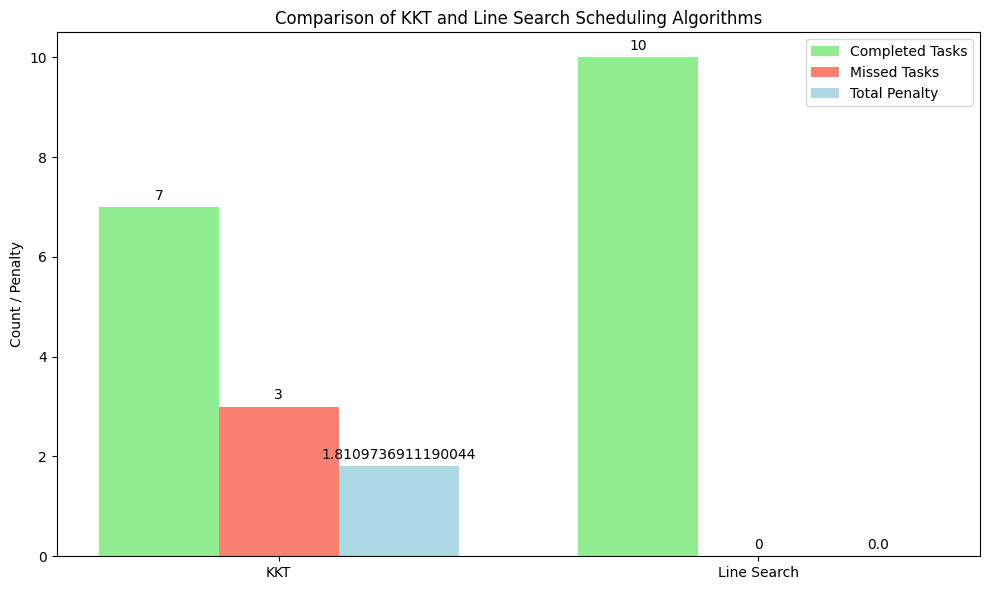

In [ ]:
import matplotlib.pyplot as plt

# Collecting results from both schedulers
kkt_completed_count = len(kkt_scheduler.completed_tasks)
kkt_missed_count = len(kkt_scheduler.missed_tasks)
kkt_penalty = kkt_scheduler.penalty

line_completed_count = len(line_scheduler.completed_tasks)
line_missed_count = len(line_scheduler.missed_tasks)
line_penalty = line_scheduler.penalty

# Data for visualization
labels = ['KKT', 'Line Search']
completed_counts = [kkt_completed_count, line_completed_count]
missed_counts = [kkt_missed_count, line_missed_count]
penalties = [kkt_penalty, line_penalty]

x = np.arange(len(labels))
width = 0.25

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# bars for completed tasks
bars1 = ax.bar(x - width, completed_counts, width, label='Completed Tasks', color='lightgreen')
# bars for missed tasks
bars2 = ax.bar(x, missed_counts, width, label='Missed Tasks', color='salmon')
# bars for penalties
bars3 = ax.bar(x + width, penalties, width, label='Total Penalty', color='lightblue')


ax.set_ylabel('Count / Penalty')
ax.set_title('Comparison of KKT and Line Search Scheduling Algorithms')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adding value annotations on top of bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

plt.tight_layout()
plt.show()
